In [1]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
from net_utils import *

In [3]:
circle = np.array([[np.cos(x),np.sin(x)] for x in np.random.rand(100)*2*np.pi])
X, Y = make_blobs(n_samples=70, centers=circle, n_features=2,
                 random_state=0,cluster_std =0.1)
r = np.random.uniform(-2,2,(200,2))
lr = (np.min(euclidean_distances(circle,r),axis = 0)>0.1)*1.
Xtrain = np.concatenate((r,X))
Ytrain = np.concatenate((lr,np.zeros(70))).astype(float)
Xtrain.shape,Ytrain.shape
Ytrain = Ytrain.reshape(-1,1)
Ytrain.shape
t = np.linspace(-2, 2,100, endpoint=False)
T = np.zeros((10100,2))
a=0
for i in t:
    for j in t:
        T[a]=np.array([i,j])
        a+=1
    a+=1

In [4]:
model = Simple_Net()
#optimizer = optim.Adam(model.parameters(), weight_decay=0.01)
optimizer = Adam_bis(model.parameters(), prec = 4,weight_decay=0)
criterion = F.binary_cross_entropy_with_logits
file_dataset = csvDataset(Xtrain,Ytrain,transform= ToTensor())
final_loader = torch.utils.data.DataLoader(file_dataset,batch_size=3, shuffle=True)
inference_dataset = csvDataset(T,np.zeros((10100,2)),transform= ToTensor())
inference_loader = torch.utils.data.DataLoader(inference_dataset,batch_size=10100, shuffle=False)

In [5]:
model,train_accuracy,eval_n,weights = train_model_cc_fast(model, final_loader,inference_loader, criterion,
    optimizer,Xtrain.shape[0], num_epochs=200)

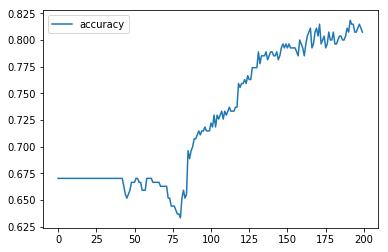

In [6]:
plt.plot(train_accuracy,label='accuracy')
plt.legend()

In [7]:
class Polynomial_Tropical_net:
    
    def __init__(self, poids,prec):

        self.poids = poids
        self.size = int(len(poids.values())/2)
        self.F=[]
        self.G=[]
        self.H=[]
        self.prec = prec
        self.shapes=[2]
        self.hyp = []
        for i in range(1,self.size+1):
            W = self.poids['f'+str(i)+'.weight']
            self.shapes.append(W.shape[0])

    def get_hypersurface(self,T):
        for i in range(T.shape[0]):
            self.generate_polynom(T[i])
            
    def trace_hypersurface(self):
        R = np.zeros((len(self.hyp),2))
        for i in range(len(self.hyp)):
            R[i]=self.hyp[i]
        plt.scatter(R[:, 0], R[:, 1], marker='o',s=25, edgecolor='k')       
    
    def stack_hypersurface(self):
        R = np.zeros((len(self.hyp),2))
        for i in range(len(self.hyp)):
            R[i]=self.hyp[i]
        return R
    
    def generate_polynom(self,x):
        
        state_f = x
        state_g = np.zeros((self.shapes[0]))
        state_h = np.zeros((self.shapes[0]))
        self.F.append(state_f)
        self.G.append(state_g)
        self.H.append(state_h)
        
        
        for i in range(1,self.size):
            W = self.poids['f'+str(i)+'.weight']
            W_plus,W_moins = decompose(W)
            b = self.poids['f'+str(i)+'.bias']
            
            #a = np.zeros((W.shape[0]))
            #c = np.zeros((W.shape[0]))
            #for k in range(W.shape[0]):
                
             #       print(W[0].shape)
                    
              #      a[k]=np.maximum(W_plus[k,:].dot(state)+b[k],0+W_moins[k,:].dot(state))
               #     b[k]=W_moins[k,:].dot(state)
            state_g_next = W_plus.dot(state_g) + W_moins.dot(state_f)
            state_h_next = W_plus.dot(state_f) + W_moins.dot(state_g)+b
            state_f_next = np.maximum(state_h_next,state_g_next+0)
            
            if (min(abs((state_h_next-state_g_next)))<self.prec):
                #print(x,'added')
                self.hyp.append(x)
            
            #print(W_plus)
            #print(state_f_next.shape,'f')
            #print(state_g_next.shape,'g')
            #print((state_h_next+b).shape,'h')
            #print((state_f_next+b-state_g_next,'out'))

            state_g,state_h,state_f=state_g_next,state_h_next,state_f_next
            
            self.F.append(state_f)
            self.G.append(state_g)
            self.H.append(state_h)
            
            #print(i , 'layer done')
            
            
            
        W = self.poids['f'+str(self.size)+'.weight']
        W_plus,W_moins = decompose(W)
        b = self.poids['f'+str(self.size)+'.bias']
        state_g_next = W_plus.dot(state_g) + W_moins.dot(state_f)
        state_h_next = W_plus.dot(state_f) + W_moins.dot(state_g)
        
        ll = state_h_next+b-state_g_next
        #print(self.size , 'layer done')
        return ll
    
    
    
    def give_polynom(self):
        
        input_size = self.poids['f1.weight'].shape[1]
        
        def id_(x):
            return x
        
        def identity(number):
            return [p]
        
        state_f = identity 
        state_g = []
        state_h = []
        self.F.append(state_f)
        self.G.append(state_g)
        self.H.append(state_h)
        
        
        for i in range(1,self.size):
            W = self.poids['f'+str(i)+'.weight']
            W_plus,W_moins = decompose(W)
            b = self.poids['f'+str(i)+'.bias']

            state_g_next = W_plus.dot(state_g) + W_moins.dot(state_f)
            state_h_next = W_plus.dot(state_f) + W_moins.dot(state_g)+b
            state_f_next = np.maximum(state_h_next,state_g_next+0)

            state_g,state_h,state_f=state_g_next,state_h_next,state_f_next
            
            self.F.append(state_f)
            self.G.append(state_g)
            self.H.append(state_h)
            
            
            
        W = self.poids['f'+str(self.size)+'.weight']
        W_plus,W_moins = decompose(W)
        b = self.poids['f'+str(self.size)+'.bias']
        state_g_next = W_plus.dot(state_g) + W_moins.dot(state_f)
        state_h_next = W_plus.dot(state_f) + W_moins.dot(state_g)
        
        ll = state_h_next+b-state_g_next
        print('c')
        return ll


In [8]:
t = np.linspace(-2, 2,100, endpoint=False)
T = np.zeros((10100,2))
a=0
for i in t:
    for j in t:
        T[a]=np.array([i,j])
        a+=1
    a+=1

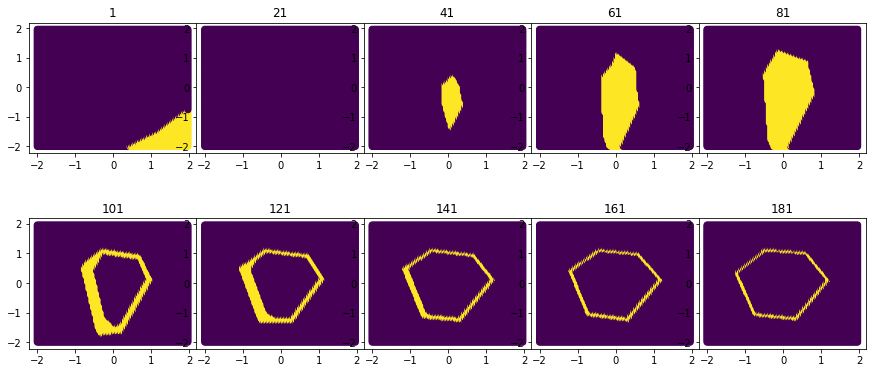

In [9]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(10):
    rr = eval_n[i*20].reshape(10100)
    axs[i].scatter(T[:, 0], T[:, 1], c =rr)
    axs[i].set_title(str(1+i*20))

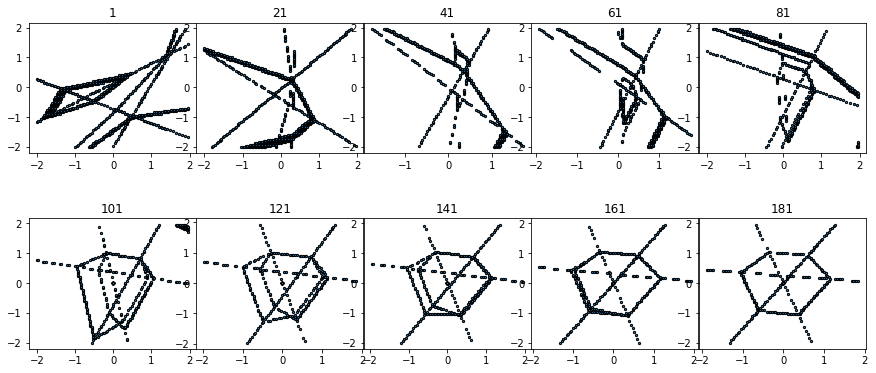

In [10]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.003)

axs = axs.ravel()

for i in range(10):
    P = Polynomial_Tropical_net(weights[1+i*20],0.009)
    P.get_hypersurface(T)
    R = P.stack_hypersurface()
    axs[i].scatter(R[:, 0], R[:, 1],marker='o',s=5, edgecolor='k')
    axs[i].set_title(str(1+i*20))

In [11]:
weights[0]['f1.weight']

array([[ 0.2561    ,  0.49629998],
       [ 0.426     , -0.64419997],
       [-0.6343    ,  0.3109    ],
       [ 0.2043    ,  0.0267    ]], dtype=float32)

In [12]:
def id_(x):
    return x

In [13]:
def id_0(x):
    return x[0]
def id_1(x):
    return x[1]

In [14]:
class myfunction:
    
    
    def __init__(self,poids):

        self.f = [id_0,id_1]
        self.poids = poids
        self.size = int(len(poids.values())/2)
        self.F = []
        self.G = []
        self.H = []
        
    def give_pol(self):
        
        state_f = self.f
        self.F.append(state_f)
        state_g = []
        
        for i in range(1,self.size):
            W = self.poids['f'+str(i)+'.weight']
            W_plus,W_moins = decompose(W)
            b = self.poids['f'+str(i)+'.bias']
            
            if i>1:
                print(len(state_f),'f',i)
                print(len(state_g),'g',i)
                print(len(state_h),'h',i)

            state_g_next = add_liste_f(array_mult_(W_plus,state_g) , array_mult_(W_moins,state_f))
            
            state_h_next = add_liste_f(array_mult_(W_plus,state_f) , array_mult_(W_moins,state_g))
            state_h_next = add_array_f(b,state_h_next)
            
            state_f_next = op_liste_ff(state_h_next,state_g_next,np.maximum)
            state_g,state_h,state_f=state_g_next,state_h_next,state_f_next
            
            self.F.append(state_f)
            self.G.append(state_g)
            self.H.append(state_h)

            
            print('ok',i)
        
        print ('last layer')
        W = self.poids['f'+str(self.size)+'.weight']
        W_plus,W_moins = decompose(W)
        b = self.poids['f'+str(self.size)+'.bias']
        
        state_g_next = add_liste_f(array_mult_(W_plus,state_g) , array_mult_(W_moins,state_f))
        state_h_next = add_liste_f(array_mult_(W_plus,state_f) , array_mult_(W_moins,state_g))
        state_h_next = add_array_f(b,state_h_next)

        return  add_liste_f(state_h_next,[mult_f(-1,state_g_next[0])])
        
        



In [15]:
def no_f(x):
    return 0

def add_f(number,f):
    def new_f(x):
        return number+f(x)
    return new_f

def add_array_f(array,f):
    j = len(f)
    k = []
    for i in range (j):
        k.append(add_f(array[i],f[i]))
    return k

def add_f_f(f,g):
    def new_f(x):
        return g(x)+f(x)
    return new_f

def add_liste_f(f,g):
    if f==[]:
        return g
    
    if g==[]:
        return f
    j = len(f)
    k = []
    for i in range (j):
        k.append(add_f_f(f[i],g[i]))
    return k

def mult_f(number,f):
    def new_f(x):
        return number*f(x)
    return new_f

def array_mult_(array,f):
    if f==[]:
        return []
    I,J = array.shape
    rez_f = [no_f for i in range(I)]
    for i in range(I):
        for j in range(J):
            rez_f[i]= add_f_f(mult_f(array[i,j],f[j]),rez_f[i])
            
    return rez_f

def op_ff(f,g,h):
    
    def new_f(x):
        return h(f(x),g(x))
    return new_f

def op_liste_ff(f,g,h):
    j = len(f)
    k = []
    for i in range (j):
        k.append(op_ff(f[i],g[i],h))
    return k

____________

In [16]:
L =myfunction(weights[0])

In [17]:
L.give_pol()

ok 1
4 f 2
4 g 2
4 h 2
ok 2
last layer


[<function __main__.add_f_f.<locals>.new_f(x)>]

In [18]:
L.give_pol()[0]((1,2))

ok 1
5 f 2
5 g 2
5 h 2
ok 2
last layer


-0.315740309087565

In [19]:
class myfunction_name:
    
    
    def __init__(self,poids):

        self.f = ['X1','X2']
        self.poids = poids
        self.size = int(len(poids.values())/2)
        self.F = []
        self.G = []
        self.H = []
        
    def give_name(self):
        
        state_f = self.f
        self.F.append(state_f)
        state_g = []
        
        for i in range(1,self.size):
            
            W = self.poids['f'+str(i)+'.weight']
            W_plus,W_moins = decompose(W)
            b = self.poids['f'+str(i)+'.bias']
            
            state_g_next = add_liste_f_name(array_mult_name(W_plus,state_g) , array_mult_name(W_moins,state_f))
            state_h_next = add_liste_f_name(array_mult_name(W_plus,state_f) , array_mult_name(W_moins,state_g))
            state_h_next = add_array_f_name(b,state_h_next)
            
            state_f_next = op_liste_ff_name(state_h_next,state_g_next,'max')
            state_g,state_h,state_f=state_g_next,state_h_next,state_f_next
            
            self.F.append(state_f)
            self.G.append(state_g)
            self.H.append(state_h)
            
            print('ok',i)
        
        print ('last layer')
        W = self.poids['f'+str(self.size)+'.weight']
        W_plus,W_moins = decompose(W)
        b = self.poids['f'+str(self.size)+'.bias']
        
        state_g_next = add_liste_f_name(array_mult_name(W_plus,state_g) , array_mult_name(W_moins,state_f))
        state_h_next = add_liste_f_name(array_mult_name(W_plus,state_f) , array_mult_name(W_moins,state_g))
        state_h_next = add_array_f_name(b,state_h_next)
        
        return  add_liste_f_name(state_h_next,[mult_f_name(-1,state_g_next[0])])

In [20]:
def add_f_name(number,f):
    if f == '':
        return str(number)
    if number==0:
        return f
    return str(number)+ ' + ' + f


def add_array_f_name(array,f):
    j = len(f)
    k = []
    for i in range (j):
        k.append(add_f_name(array[i],f[i]))
    return k

def add_f_f_name(f,g):
    if f == '':
        return g
    if g == '':
        return f
    return f + ' + ' + g

def add_liste_f_name(f,g):
    if f==[]:
        return g
    
    if g==[]:
        return f
    j = len(f)
    k = []
    for i in range (j):
        k.append(add_f_f_name(f[i],g[i]))
    return k

def mult_f_name(number,f):
    if number == 0:
        return ''
    return str(number)+' * ' + f

def array_mult_name(array,f):
    if f==[]:
        return []
    I,J = array.shape
    rez_f = ['' for i in range(I)]
    for i in range(I):
        for j in range(J):
            rez_f[i]= add_f_f_name(mult_f_name(array[i,j],f[j]),rez_f[i])
    return rez_f

def op_ff_name(f,g,h):
    if g=='':
        g='0'
    if f=='':
        f='0'    
    return h + '(' + f + ',' + g +')'

def op_liste_ff_name(f,g,h):
    j = len(f)
    k = []
    for i in range (j):
        k.append(op_ff_name(f[i],g[i],h))
    return k

In [21]:
LL =myfunction_name(weights[0])

In [22]:
LL.give_name()

ok 1
ok 2
last layer


['-0.3294 + 0.1209 * max(0.3954 + 0.2382 * max(-0.2908 + 0.2223 * X2,0.12879999 * X1) + 0.21669999 * max(-0.4552 + 0.4495 * X1,0.24939999 * X2) + 0.47939998 * max(-0.04 + 0.6929 * X2 + 0.092199996 * X1,0) + 0.3225 * 0.2557 * X1 + 0.248 * ,0.2382 * 0.12879999 * X1 + 0.21669999 * 0.24939999 * X2 + 0.47939998 *  + 0.3225 * max(-0.6387 + 0.4718 * X2,0.2557 * X1) + 0.248 * max(-0.72679996 + 0.5239 * X2 + 0.2482 * X1,0)) + 0.46739998 * max(0.1769 + 0.0128 * max(-0.2908 + 0.2223 * X2,0.12879999 * X1) + 0.092199996 * max(-0.04 + 0.6929 * X2 + 0.092199996 * X1,0) + 0.35779998 * max(-0.6387 + 0.4718 * X2,0.2557 * X1) + 0.12619999 * 0.24939999 * X2 + 0.2936 * ,0.0128 * 0.12879999 * X1 + 0.092199996 *  + 0.35779998 * 0.2557 * X1 + 0.12619999 * max(-0.4552 + 0.4495 * X1,0.24939999 * X2) + 0.2936 * max(-0.72679996 + 0.5239 * X2 + 0.2482 * X1,0)) + 0.26 * 0.0341 * 0.12879999 * X1 + 0.1743 *  + 0.1589 *  + 0.1735 * max(-0.4552 + 0.4495 * X1,0.24939999 * X2) + 0.0133 * max(-0.6387 + 0.4718 * X2,0.2557 

In [23]:
LL.F[1]

['max(-0.72679996 + 0.5239 * X2 + 0.2482 * X1,0)',
 'max(-0.6387 + 0.4718 * X2,0.2557 * X1)',
 'max(-0.04 + 0.6929 * X2 + 0.092199996 * X1,0)',
 'max(-0.4552 + 0.4495 * X1,0.24939999 * X2)',
 'max(-0.2908 + 0.2223 * X2,0.12879999 * X1)']

In [24]:
LL.G[0]

['', '0.2557 * X1', '', '0.24939999 * X2', '0.12879999 * X1']

In [25]:
LL.H[0]

['-0.72679996 + 0.5239 * X2 + 0.2482 * X1',
 '-0.6387 + 0.4718 * X2',
 '-0.04 + 0.6929 * X2 + 0.092199996 * X1',
 '-0.4552 + 0.4495 * X1',
 '-0.2908 + 0.2223 * X2']

In [26]:
L.F[1][0]((0,1)),L.F[1][0]((1,0)),L.F[1][0]((0,0))

(0.0, 0.0, 0.0)

In [27]:
weights[0]['f1.weight']

array([[ 0.2482    ,  0.5239    ],
       [-0.2557    ,  0.4718    ],
       [ 0.0922    ,  0.6929    ],
       [ 0.4495    , -0.24939999],
       [-0.12879999,  0.2223    ]], dtype=float32)

In [28]:
weights[0]['f1.bias']

array([-0.72679996, -0.6387    , -0.04      , -0.4552    , -0.2908    ],
      dtype=float32)

_____________

_____________


class myfunction_simple:
    
    
    def __init__(self,poids):

        self.f = [id_0,id_1]
        self.poids = poids
        self.size = int(len(poids.values())/2)
        self.F = []
        self.G = []
        self.H = []

        
    def give_pol(self):
        
        state_f = self.f
        state_g = []

        self.F.append(state_f)
        self.G.append(state_g)

        
        for i in range(1,self.size):
            W = self.poids['f'+str(i)+'.weight']
            W_plus,W_moins = decompose(W)
            b = self.poids['f'+str(i)+'.bias']
            
            if i==1:
                
                state_g_next = [[]]
                state_f_next = array_mult_(W,state_f)
                state_f_next = add_array_f(b,state_f_next)                
                
                state_g,state_f=state_g_next,[[i] for i in state_f_next]

                self.F.append(state_f)
                self.G.append(state_g)

            
            if i>1:
                print(len(state_f),'f',i)
                print(len(state_g),'g',i)
                print('test')
                d = array_mult_simple(W_plus,state_f)
                print('test')

                state_g_next = add_ll_f_simple(array_mult_simple(W_plus,state_g) , array_mult_simple(W_moins,state_f))

                state_f_next = add_ll_f_simple(array_mult_simple(W_plus,state_f) , array_mult_simple(W_moins,state_g))
                
                state_f_next = add_array_f_simple(b,state_f_next)

                state_g,state_f=state_g_next,state_f_next

                self.F.append(state_f)
                self.G.append(state_g)
            
            print('ok',i)
            
        print ('last layer')
        
        W = self.poids['f'+str(self.size)+'.weight']
        W_plus,W_moins = decompose(W)
        b = self.poids['f'+str(self.size)+'.bias']
        
        print(len(state_f),'f',i)
        print(len(state_g),'g',i)
        
        state_g_next = add_ll_f_simple(array_mult_simple(W_plus,state_g) , array_mult_simple(W_moins,state_f))
        state_f_next = add_ll_f_simple(array_mult_simple(W_plus,state_f) , array_mult_simple(W_moins,state_g))
        
        print(len(state_f_next),'f','next',len(state_f_next))
        print(len(state_g_next),'g','next',len(state_f_next))
        
        state_f_next = add_f_simple(b,state_f_next)

        #return  add_liste_f(state_h_next,[mult_f(-1,state_g_next[0])])
        state_g,state_f=state_g_next,state_f_next
        
        self.F.append(state_f)
        self.G.append(state_g)

## SIMPLIFICATION FORME FONCTIONNELLE

In [34]:

class myfunction_simple:
    
    
    def __init__(self,poids):

        self.f = [id_0,id_1]
        self.poids = poids
        self.size = int(len(poids.values())/2)
        self.F = []
        self.G = []
        self.H = []

        
    def give_pol(self):
        
        state_f = self.f
        state_g = []
        state_h = []
        self.F.append(state_f)
        self.G.append(state_g)
        self.H.append(state_h)
        
        for i in range(1,self.size):
            W = self.poids['f'+str(i)+'.weight']
            W_plus,W_moins = decompose(W)
            b = self.poids['f'+str(i)+'.bias']
                        
            if i ==1:
                
            
                state_g_next = array_mult_ss(W_moins,state_f)
                
                state_h_next = array_mult_ss(W_plus,state_f)
                state_h_next = add_array_f_simple(b,state_h_next)
                
                
                
                state_f_next = conc_f_simple(state_h_next,state_g_next)
                
                state_g,state_h,state_f=state_g_next,state_h_next,state_f_next

                self.F.append(state_f)
                self.G.append(state_g)
                self.H.append(state_h)
            
            if i>1:
                    
                    
                state_g_next = add_ll_f_simple(array_mult_simple(W_plus,state_g) , array_mult_simple(W_moins,state_f))
                print('half')
                state_h_next = add_ll_f_simple(array_mult_simple(W_plus,state_f) , array_mult_simple(W_moins,state_g))
                state_h_next = add_array_f_simple(b,state_h_next)

                state_f_next = conc_f_simple(state_h_next,state_g_next)

                state_g,state_h,state_f=state_g_next,state_h_next,state_f_next

                self.F.append(state_f)
                self.G.append(state_g)
                self.H.append(state_h)
            
            print('ok',i)

In [18]:
def mult_ss(array,lf):
    
    ' mult_ss supposed to give a list given a list and a vector'
    'ok'
    if lf ==[]:
        return []   
    r = no_f
    l = len(lf)
    for j in range(l):
        r = add_f_f(r,mult_f(array[j],lf[j]))      
    return [r]


def array_mult_ss(array,lf):
    'starts with id liste, give list of list'
    if lf==[]:
        return [[]]
    I,J = array.shape
    rez_lf = []
    
    for i in range(I):            
        rez_lf.append(mult_ss(array[i,:],lf)) 
        ' mult_ss give a list given a list and a vector'
    return rez_lf

In [19]:
def mult_simple(number,lf):
    
    
    ' mult_simple is supposed to return a list given a number and a list'
    'OK'
    if lf ==[]:
        return []
    
    r = []
    l = len(lf)
    for j in range(l):
        r.append(mult_f(number,lf[j]))
        
    return r

def mult_f_simple(number_array,llf):
    
    'mult_f_simple is supposed to return a list of functions given a vector and a list of list'
    ' OK ' 
    if llf ==[[]]:
        return [[]]
    
    r = []
    l = len(llf)
    for j in range(l):
        print(j)
        r = add_liste_f_simple(r,mult_simple(number_array[j],llf[j]))
        ' mult_simple is supposed to return a list given a number and a list'
    return r

def array_mult_simple(array,llf):
    'FIRST'
    " given a matrix, a list of list of functions, returns a list of list of functions"
    if llf==[[]]:
        return [[]]
    I,J = array.shape
    rez_llf = []
    
    for i in range(I):            
        rez_llf.append(mult_f_simple(array[i,:],llf)) 
        " hence mult_f_simple is supposed to return a list of functions given a vector and a list of list"
    return rez_llf


def add_liste_f_simple(lf,lg):
    if lf==[]:
        return lg
    if lg==[]:
        return lf
    k = []
    print(len(lf),len(lg))
    for i in lf:
        for j in lg:
            k.append(add_f_f(i,j))
    return k

'''
------------------------------------------------------------------------------------------------
'''



def add_ll_f_simple(llf,llg):
    
    " given two lists of list return one list of lists adding term by term with a max"
     
    if llf==[[]]:
        return llg
    if llg==[[]]:
        return llf
    l = len(llf)
    return [add_liste_f_simple(llf[i],llg[i]) for i in range(l)]

def conc_f_simple(llf,llg):
    'OK'
    if llf==[[]]:
        return llg
    if llg==[[]]:
        return llf
    l = len(llf)
    return [llf[i]+llg[i] for i in range(l)]

'''
------------------------------------------------------------------------------------------------
'''


def add_f_simple(number,lf):
    if lf ==[]:
        return []
    j = len(lf)
    k = []
    for i in range (j):
        k.append(add_f(number,lf[i]))
    return k

def add_array_f_simple(array,llf):
    j = len(llf)
    k = []
    for i in range (j):
        k.append(add_f_simple(array[i],llf[i]))
    return k

def mult_f_simple(number_array,llf):
    if llf ==[]:
        return []
    
    r = []
    l = len(lf)
    for j in range(l):
        def new_f(x):
            return number_array[j]*lf(j)(x)
        r.append(new_f)
        
    return r

def array_mult_simple(array,llf):
    if llf==[[]]:
        return [[]]
    I,J = array.shape
    rez_llf = []
    
    for i in range(I):            
        rez_llf.append(mult_f_simple(array[i,:],llf)) 
        
    return rez_llf

In [20]:
LL_simple =myfunction_simple(weights[199])

NameError: name 'myfunction_simple' is not defined

In [38]:
LL_simple.give_pol()

ok 1
0
1
1 1
2
1 1
3
1 1
4
1 1
0
1
1 1
2
1 1
3
1 1
4
1 1
0
1
1 1
2
1 1
3
1 1
4
1 1
0
1
1 1
2
1 1
3
1 1
4
1 1
0
1
1 1
2
1 1
3
1 1
4
1 1
0
1
2 2
2
4 2
3
8 2
4
16 2
0
1
2 2
2
4 2
3
8 2
4
16 2
0
1
2 2
2
4 2
3
8 2
4
16 2
0
1
2 2
2
4 2
3
8 2
4
16 2
0
1
2 2
2
4 2
3
8 2
4
16 2
1 32
1 32
1 32
1 32
1 32
half
0
1
2 2
2
4 2
3
8 2
4
16 2
0
1
2 2
2
4 2
3
8 2
4
16 2
0
1
2 2
2
4 2
3
8 2
4
16 2
0
1
2 2
2
4 2
3
8 2
4
16 2
0
1
2 2
2
4 2
3
8 2
4
16 2
0
1
1 1
2
1 1
3
1 1
4
1 1
0
1
1 1
2
1 1
3
1 1
4
1 1
0
1
1 1
2
1 1
3
1 1
4
1 1
0
1
1 1
2
1 1
3
1 1
4
1 1
0
1
1 1
2
1 1
3
1 1
4
1 1
32 1
32 1
32 1
32 1
32 1
ok 2


________________

## TEST


In [39]:
LL_simple.F[0]

[<function __main__.id_0(x)>, <function __main__.id_1(x)>]

In [40]:
len(LL_simple.F[1]),len(LL_simple.F[1][0])

(5, 2)

In [43]:
test(LL_simple.F[1][0][0])

-0.8167999982833862
0.0828000009059906
0.359499990940094


In [44]:
test(LL_simple.G[1][0][0])

0.0
0.0
0.0


In [45]:
test(LL_simple.H[1][0][0])

-0.8167999982833862
0.0828000009059906
0.359499990940094


In [46]:
weights[199]['f1.weight']

array([[ 0.0828    ,  0.3595    ],
       [-0.489     , -0.0068    ],
       [ 0.2522    ,  0.6766    ],
       [ 0.24689999, -0.5841    ],
       [ 0.2729    ,  0.1462    ]], dtype=float32)

In [47]:
weights[199]['f1.bias']

array([-8.1680000e-01, -1.2239999e-01, -9.7499996e-02,  3.4999999e-03,
        9.9999997e-05], dtype=float32)

___________________

___________________

___________________

In [48]:
len(LL_simple.F[2]),len(LL_simple.F[2][0])

(5, 64)

In [49]:
len(LL_simple.G[2]),len(LL_simple.G[2][0])

(5, 32)

In [50]:
len(LL_simple.H[2]),len(LL_simple.H[2][0])

(5, 32)

___________________

___________________

In [51]:
len(LL_simple.F[3]),len(LL_simple.F[3][0])

IndexError: list index out of range

In [857]:
len(LL_simple.G[3]),len(LL_simple.G[3][0])

(1, 125000)

In [858]:
len(LL_simple.H[3]),len(LL_simple.H[3][0])

(1, 125000)

In [42]:
def test(f):
    print(f((0,0)))
    print(f((1,0))-f((0,0)))
    print(f((0,1))-f((0,0)))

In [926]:
h = np.max([x((1,2)) for x in LL_simple.H[3][0]])

In [901]:
g = np.max([x((1,2)) for x in LL_simple.G[3][0]])

In [902]:
h-g

-0.25145502418237253

In [868]:
x = torch.tensor((1,2)).float().cuda()
model.forward(x)

tensor([6.9162], device='cuda:0', grad_fn=<AddBackward0>)

In [865]:
weights[199]

{'f1.weight': array([[ 0.1898    ,  0.18869999],
        [-0.0046    , -0.4375    ],
        [ 0.23099999,  0.0146    ],
        [-0.33359998, -0.0018    ],
        [-0.23809999,  0.5143    ]], dtype=float32),
 'f1.bias': array([-0.0021, -0.0866, -0.0703, -0.1864, -0.0684], dtype=float32),
 'f2.weight': array([[0.29839998, 0.6164    , 0.9025    , 0.8481    , 0.3184    ],
        [0.2994    , 0.5674    , 0.7898    , 0.79249996, 0.28079998],
        [0.53529996, 0.9381    , 1.2383    , 1.2916    , 0.4612    ],
        [0.2298    , 0.4272    , 0.5924    , 0.59639996, 0.2096    ],
        [0.0717    , 1.1632    , 1.049     , 0.4075    , 1.1631    ]],
       dtype=float32),
 'f2.bias': array([-0.22219999, -0.2041    , -0.33449998, -0.15519999,  0.1146    ],
       dtype=float32),
 'f3.weight': array([[ 5.3101997,  5.5599   ,  7.3687997,  3.3086998, -1.2031   ]],
       dtype=float32),
 'f3.bias': array([-0.0009], dtype=float32)}

In [866]:
for i,j in model.named_parameters():
    print(j)

Parameter containing:
tensor([[ 0.1898,  0.1887],
        [-0.0046, -0.4375],
        [ 0.2310,  0.0146],
        [-0.3336, -0.0018],
        [-0.2381,  0.5143]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0021, -0.0866, -0.0703, -0.1864, -0.0684], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[0.2984, 0.6164, 0.9025, 0.8481, 0.3184],
        [0.2994, 0.5674, 0.7898, 0.7925, 0.2808],
        [0.5353, 0.9381, 1.2383, 1.2916, 0.4612],
        [0.2298, 0.4272, 0.5924, 0.5964, 0.2096],
        [0.0717, 1.1632, 1.0490, 0.4075, 1.1631]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.2222, -0.2041, -0.3345, -0.1552,  0.1146], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[ 5.3102,  5.5599,  7.3688,  3.3087, -1.2031]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0009], device='cuda:0', requires_grad=True)


_____________

In [52]:
L =myfunction(weights[199])

In [53]:
L.give_pol()[0]((1,2))

ok 1
5 f 2
5 g 2
5 h 2
ok 2
last layer


6.792438892227194

_______________

In [54]:
L.F[1][0]((1,2))

0.0

In [55]:
[x((1,2)) for x in LL_simple.F[1][0]]

[-0.015000015497207642, 0.0]

In [56]:
L.G[0][0]((1,2)),L.H[0][0]((1,2))

(0.0, -0.015000015497207642)

In [57]:
[x((1,2)) for x in LL_simple.G[1][0]],[x((1,2)) for x in LL_simple.H[1][0]]

([0.0], [-0.015000015497207642])

## OK couche 1

____________________

In [58]:
L.F[2][0]((1,2))

2.412388215323671

In [59]:
np.max([x((1,2)) for x in LL_simple.F[2][0]])

2.412388215323671

In [60]:
L.G[1][0]((1,2)),L.H[1][0]((1,2))

(1.5836581931495752, 2.412388215323671)

In [61]:
np.max([x((1,2)) for x in LL_simple.G[2][0]]),np.max([x((1,2)) for x in LL_simple.H[2][0]])

(1.5836581931495752, 2.412388215323671)

## OK couche 2

_____________________

_____________________

_____________________

# forme ax1+bx2+c

In [21]:
class my_final:
    
    
    def __init__(self,poids):

        self.f = [np.array([1,0,0]),np.array([0,1,0])]
        self.poids = poids
        self.size = int(len(poids.values())/2)
        self.F = []
        self.G = []
        self.H = []

        
    def give_pol(self):
        
        state_f = self.f
        state_g = []
        state_h = []
        self.F.append(state_f)
        self.G.append(state_g)
        self.H.append(state_h)
        
        for i in range(1,self.size+1):
        #for i in range(1,2):
            W = self.poids['f'+str(i)+'.weight']
            W_plus,W_moins = decompose(W)
            b = self.poids['f'+str(i)+'.bias']
                        
            if i ==1:
                
            
                state_g_next = array_mult_final_l(W_moins,state_f)
                
                state_h_next = array_mult_final_l(W_plus,state_f)
                state_h_next = add_array_f_final(b,state_h_next)
                
                
                
                state_f_next = conc_f_simple(state_h_next,state_g_next)
                
                state_g,state_h,state_f=state_g_next,state_h_next,state_f_next

                self.F.append(state_f)
                self.G.append(state_g)
                self.H.append(state_h)
            
            if i>1:
                    
                    
                state_g_next = add_ll_f_final(array_mult_final_ll(W_plus,state_g) , array_mult_final_ll(W_moins,state_f))
                print('half')
                state_h_next = add_ll_f_final(array_mult_final_ll(W_plus,state_f) , array_mult_final_ll(W_moins,state_g))
                state_h_next = add_array_f_final(b,state_h_next)

                state_f_next = conc_f_simple(state_h_next,state_g_next)

                state_g,state_h,state_f=state_g_next,state_h_next,state_f_next

                self.F.append(state_f)
                self.G.append(state_g)
                self.H.append(state_h)
            
            print('ok',i)

In [22]:
def mult_final_a(array,lf):
    
    ' mult_ss supposed to give a list given a list and a vector'
    'ok'
    if lf ==[]:
        return []   
    r = np.array([0.,0.,0.])
    l = len(lf)
    for j in range(l):
        r += array[j]*lf[j]      
    return [r]


def array_mult_final_l(array,lf):
    if lf==[]:
        return [[]]
    I,J = array.shape
    rez_lf = []
    
    for i in range(I):            
        rez_lf.append(mult_final_a(array[i,:],lf)) 
    return rez_lf


def add_f_final(number,lf):
    if lf ==[]:
        return []
    j = len(lf)
    k = []
    for i in range (j):
        lf[i][2]+= number
    return k

def add_array_f_final(array,llf):
    j = len(llf)
    for i in range (j):
        add_f_final(array[i],llf[i])
    return llf

In [28]:
LL_final = my_final(weights[199])

In [29]:
LL_final.give_pol()

ok 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 2
6 2
12 2
24 2
3 2
6 2
12 2
24 2
3 2
6 2
12 2
24 2
3 2
6 2
12 2
24 2
3 48
3 48
3 48
3 48
half
3 2
6 2
12 2
24 2
3 2
6 2
12 2
24 2
3 2
6 2
12 2
24 2
3 2
6 2
12 2
24 2
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
48 3
48 3
48 3
48 3
ok 2
3 144
432 144
62208 144


/home/gregoire/anaconda3/envs/pytorch_fury/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


8957952 144


KeyboardInterrupt: 

In [25]:
LL_final.F[1][0]

[array([ 0.0809    ,  0.90719998, -0.1892    ]), array([0., 0., 0.])]

In [26]:
def mult_final_n(number,lf):
    
    
    ' mult_simple is supposed to return a list given a number and a list'
    'OK'
    if lf ==[]:
        return []
    
    r = []
    l = len(lf)
    for j in range(l):
        r.append(number*lf[j])
        
    return r

def mult_f_final(number_array,llf):
    
    'mult_f_simple is supposed to return a list of functions given a vector and a list of list'
    ' OK ' 
    if llf ==[[]]:
        return [[]]
    
    r = np.array([0.,0.,0.])
    l = len(llf)
    for j in range(l):
        r = add_liste_f_final(r,mult_final_n(number_array[j],llf[j]))
        ' mult_simple is supposed to return a list given a number and a list'
    return r

def array_mult_final_ll(array,llf):
    'FIRST'
    " given a matrix, a list of list of functions, returns a list of list of functions"
    if llf==[[]]:
        return [[]]
    I,J = array.shape
    rez_llf = []
    
    for i in range(I):            
        rez_llf.append(mult_f_final(array[i,:],llf)) 
        " hence mult_f_simple is supposed to return a list of functions given a vector and a list of list"
    return rez_llf


def add_liste_f_final(lf,lg):
    if lf==[]:
        return lg
    if lg==[]:
        return lf
    k = []
    print(len(lf),len(lg))
    for i in lf:
        for j in lg:
            k.append(i+j)
    return k

'''
------------------------------------------------------------------------------------------------
'''



def add_ll_f_final(llf,llg):
    
    " given two lists of list return one list of lists adding term by term with a max"
     
    if llf==[[]]:
        return llg
    if llg==[[]]:
        return llf
    l = len(llf)
    return [add_liste_f_final(llf[i],llg[i]) for i in range(l)]


def simplify_final(lf):
    